## Life history traits model   

Taylor Chapter 3  
model to predict age-structured life history traits of understudied Carcharhinid species

Model versions: Same as models 22 & 23 except altered to enable prediction. one fixed-effect and one mixed-effect. covariates here are mean centred rather than z scores.  Need this because effect sizes need to be on the same scale as the raw data in order to calculate predicted values for a50 and s


### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

# Function to mean-centre covariates
def centre(x):
    return (x-np.mean(x))

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.csv',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [8]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]

In [9]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [10]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(526, 37)

In [11]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])

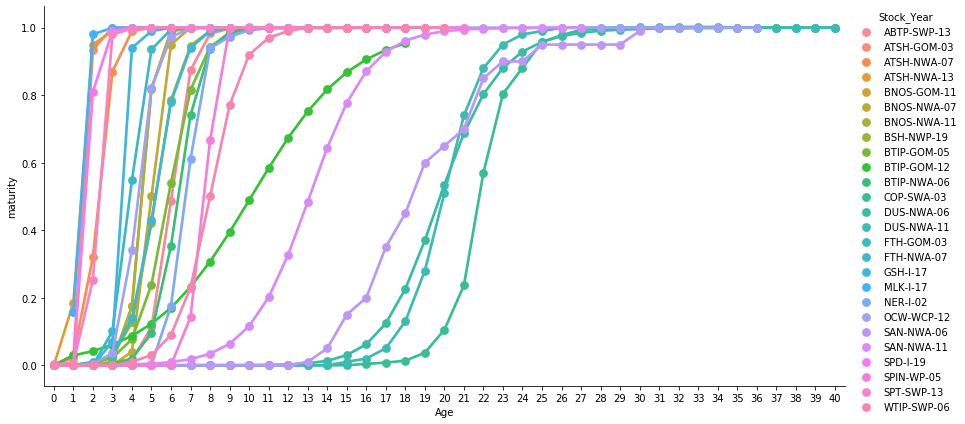

In [12]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [13]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [14]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BSH-NWP-19',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GSH-I-17',
 'MLK-I-17',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPD-I-19',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [15]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
rLMAX = mdata.lmax_cm.values[Sind]
rHAB = mdata.habitat.values[Sind]
rTROPH = mdata.trophic_level.values[Sind]
rOFFSZ = mdata.offspring_size_mm.values[Sind]
#rROFFSZ = mdata.relative_offspring_size.values[Sind]
rLITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
rINTR = mdata.interbirth_interval_yrs.values[Sind]
rAMAT = mdata.age_50_maturity.values[Sind]
rLMAT = mdata.length_maturity_cm.values[Sind]
rLINF = mdata.linf_cm.values[Sind]
rK = mdata.growth_coeff_k.values[Sind]
rAMAX = mdata.age_max_yrs.values[Sind]
rDEP = mdata.depth_ave.values[Sind]
rDEPMAX = mdata.depth_max.values[Sind]
rTEMP = mdata.temp_pref.values[Sind]

In [16]:
np.mean(rTEMP)

24.165384615384617

In [17]:
# mean centre all covariates
#change variable names

LMAX = centre(np.log(rLMAX))
TROPH = centre(rTROPH)
OFFSZ = centre(rOFFSZ/100)
LITT = centre(np.log(rLITT))
INTR = centre(rINTR)
LMAT = centre(rLMAT)
LINF = centre(np.log(rLINF))
K = centre(rK)
AMAX = centre(np.log(rAMAX))
DEP = centre(np.log(rDEP))
DEPMAX = centre(np.log(rDEPMAX))
TEMP = centre(np.log(rTEMP))

In [18]:
TEMP

array([-0.03688139,  0.06630284,  0.06630284,  0.06630284, -0.10432268,
       -0.10432268, -0.10432268, -0.47774843,  0.08572093,  0.08572093,
        0.08572093, -0.3159054 , -0.22793663, -0.22793663, -0.09046564,
       -0.09046564,  0.18103111,  0.12346126,  0.08572093,  0.14181039,
        0.13084136,  0.13084136,  0.12346126,  0.1381674 ,  0.12346126,
        0.14544016])

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

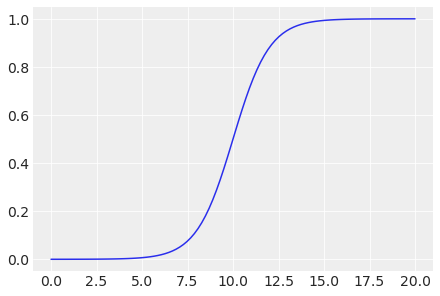

In [54]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

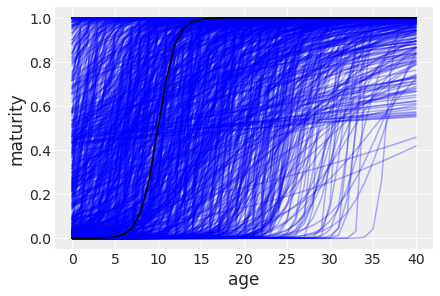

In [55]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('age', fontsize=17)
plt.ylabel('maturity', fontsize=17);

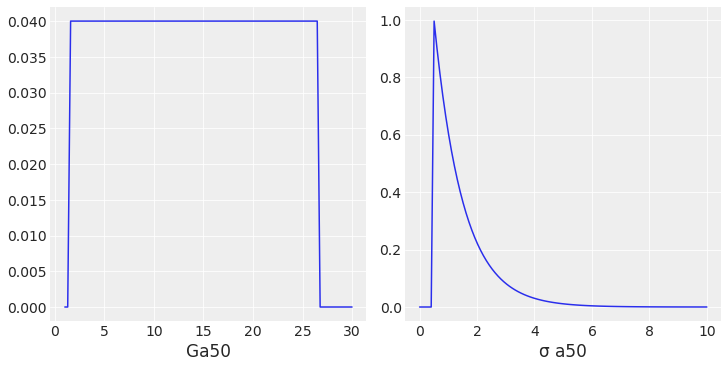

In [56]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 1 and 30
x = np.linspace(1, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

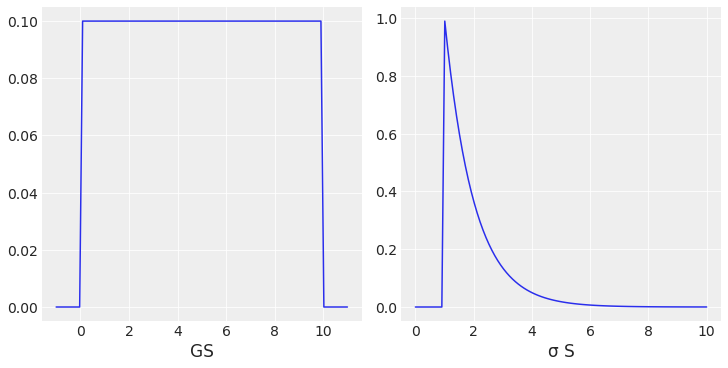

In [57]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [22]:
# random effects model with full covs
# Model 24
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
   # a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50, 1 dist. per stockyear 
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
   # β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
    β12 = pm.Normal('Temperature', 0, 3)
    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
     
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
   # B8 = pm.Normal('Litter-S', 0, 3)
   # B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β11*LMAT + β12*TEMP)
    a50 = pm.Normal('a50x', mu_a50, a50_sigma, shape=nstocks)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", GS + B1*LMAX + B3*DEP + B4*K + B7*AMAX + B10*TROPH + B11*LMAT + B12*TEMP)
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [25]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Sx, a50x, Temperature-S, Lmat-S, Trophic-S, Amax-S, K-S, Depth-S, Lmax-S, S_sigma, GS, Lmat, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, a50_sigma, Ga50]


RuntimeError: Chain 0 failed.

In [ ]:
#check model performance
pm.traceplot(trace1);

In [ ]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging

In [ ]:
# Model 25
# random effects model with limited covariates
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
   # a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
  #  β4 = pm.Normal('K', 0, 3)
  #  β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
  #  β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
   # β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
    β11 = pm.Normal('Lmat', 0, 3) 
    β12 = pm.Normal('Temperature', 0, 3)
    
    # Hierarchical S
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
 #   B4 = pm.Normal('K-S', 0, 3)
  #  B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
  #  B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
  #  B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
   # B8 = pm.Normal('Litter-S', 0, 3)
   # B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
   # B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β6*INTR +  β8*LITT + β9*OFFSZ + β10*TROPH + β11*LMAT + β12*TEMP)
    a50 = pm.Normal('a50x', mu_a50, a50_sigma, shape=nstocks) #stock level

    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", GS + B1*LMAT + B3*DEP + B10*TROPH + B12*TEMP)
    S = pm.Normal('Sx', mu_S, S_sigma, shape=nstocks) 
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [ ]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

In [ ]:
#check model performance
pm.traceplot(trace2);

In [ ]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

In [28]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace1)
pm.save_trace(trace2)

'.pymc_11.trace'

### Model Results

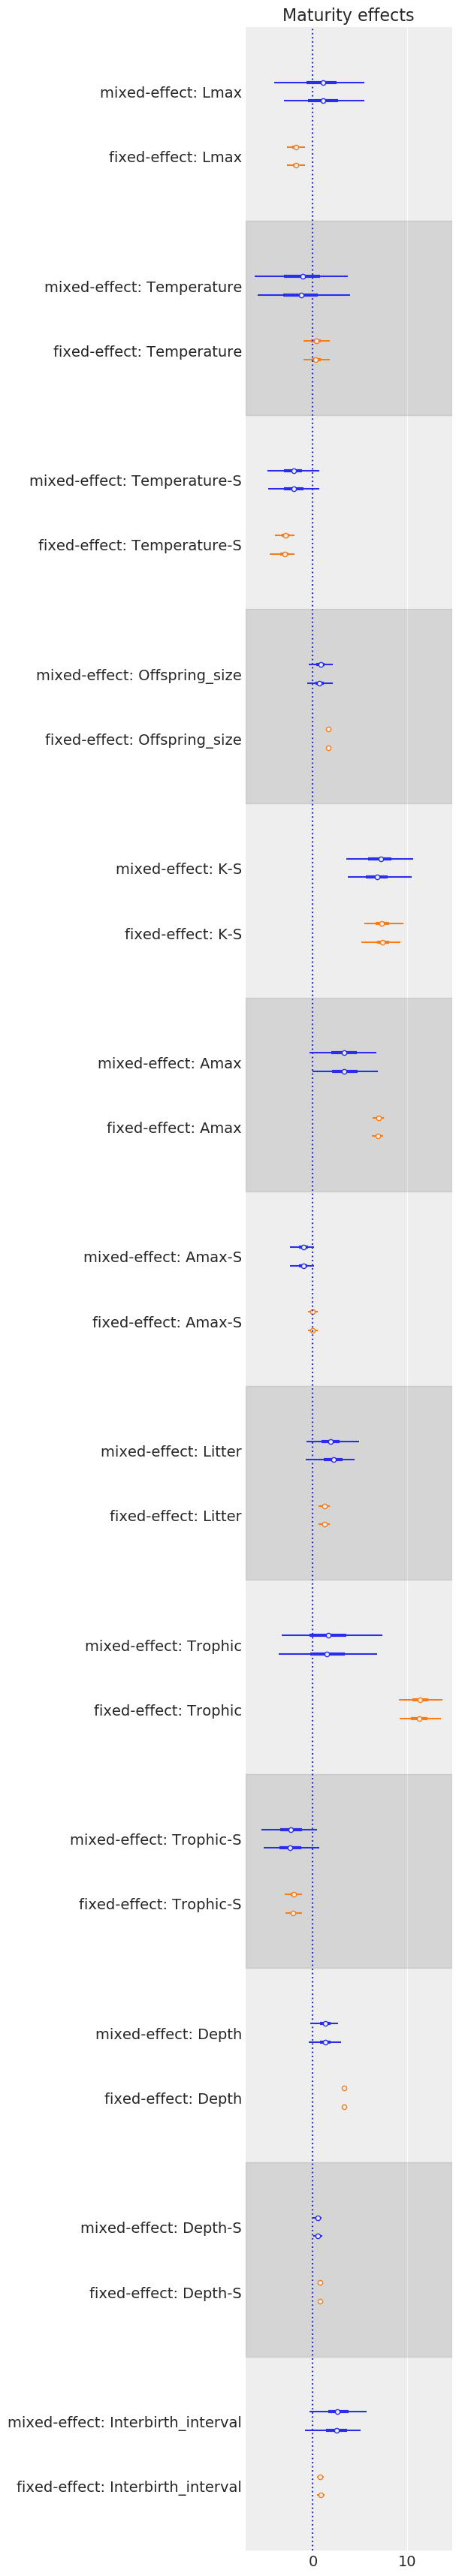

<Figure size 720x480 with 0 Axes>

In [30]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1, trace2], model_names=["mixed-effect", "fixed-effect"], var_names=["Lmax", "Temperature", "Temperature-S", "Offspring_size", "K-S", "Amax", "Amax-S", "Litter", "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat18&19_forest.jpg');

### Model Comparison

In [7]:
# upload trace
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
#pm.backends.ndarray.load_trace(pymc_4.trace, model=mat2)
trace2 = pm.load_trace('.pymc_4.trace', model=mat2)

In [31]:
#WAIC for model 1
pm.waic(trace1, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 485 log-likelihood matrix

              Estimate       SE
deviance_waic -3137.96   122.64
p_waic           87.88        -

There has been a warning during the calculation. Please check the results.

In [32]:
#WAIC for model 2
pm.waic(trace2, scale='deviance')

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 485 log-likelihood matrix

              Estimate       SE
deviance_waic    32.45   159.32
p_waic          129.94        -

There has been a warning during the calculation. Please check the results.

Model 1 WAIC = -3137
Model 2 WAIC = 32



#### Look for 'bad' datapoints

In [33]:
loo2 = pm.loo(trace2, mat2)
loo2

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 485 log-likelihood matrix

         Estimate       SE
elpd_loo   -16.03    79.18
p_loo      129.74        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      442   91.1%
 (0.5, 0.7]   (ok)         19    3.9%
   (0.7, 1]   (bad)        19    3.9%
   (1, Inf)   (very bad)    5    1.0%

In [34]:
loo1 = pm.loo(trace1, mat1)
loo1

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 485 log-likelihood matrix

         Estimate       SE
elpd_loo  1561.52    60.26
p_loo       95.35        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      445   91.8%
 (0.5, 0.7]   (ok)          8    1.6%
   (0.7, 1]   (bad)        21    4.3%
   (1, Inf)   (very bad)   11    2.3%

In [35]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fits

In [36]:
#Save results to external file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#mat 18
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)
result1.to_csv('mat18_model_results.csv')
#mat 19
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)
result2.to_csv('mat19_model_results.csv')

In [10]:
# Reload results file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#result2 = pd.read_csv('mat14_model_results.csv')

In [37]:
# Grab data from mat18 results
# Grab a50's
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T
a50s = np.array([np.median(result1[x]) for x in np.array(['a50x__'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['Sx__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [38]:
#Grab data from mat2 (model 19 results)
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s2 = np.array([np.median(result2[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T


# Grab S's
μSs2 = np.array([np.median(result2[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T

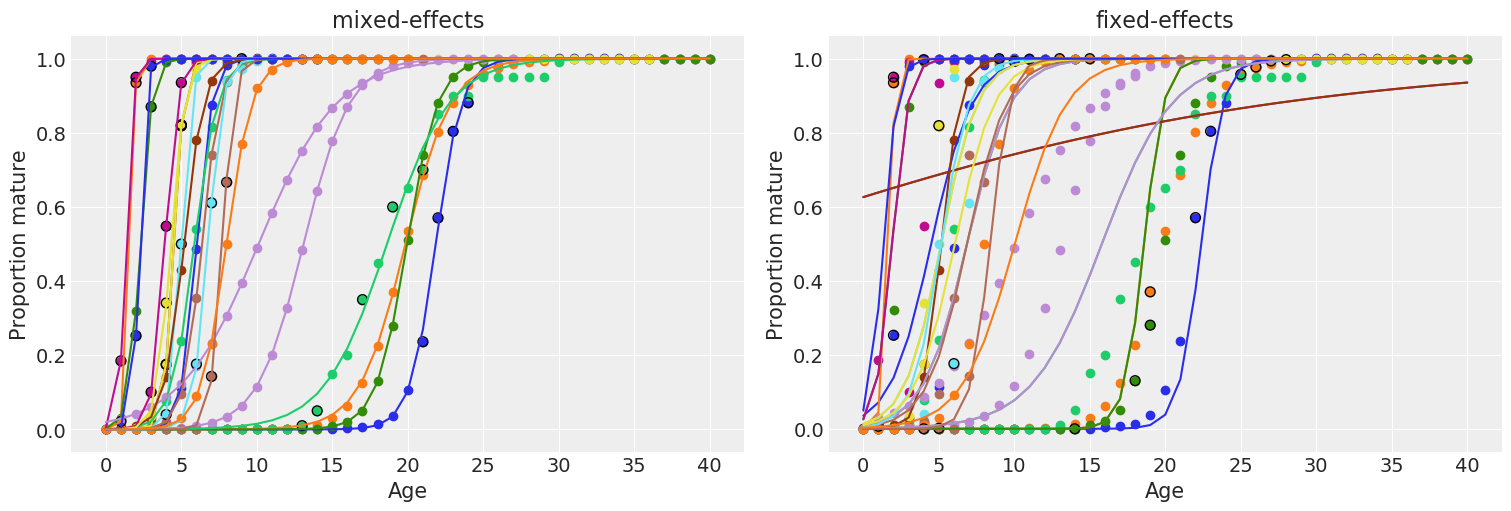

In [39]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))
ax_ = axes.flatten()

#Plot mat16
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-effects')

#Plot mat17
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('fixed-effects')

#save results
plt.savefig('mat18_mat19_modelfit.jpg',dpi=300);